In [1]:
# Mitigating noise on real quantum computer
import qiskit

# qiskit version
qiskit.__qiskit_version__

{'qiskit-terra': '0.19.2', 'qiskit-aer': '0.10.3', 'qiskit-ignis': '0.7.0', 'qiskit-ibmq-provider': '0.18.3', 'qiskit-aqua': None, 'qiskit': '0.34.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import os
# Don't be confuse with the `IBMQ_API` is an environment variable
# of my system which I gave a value of my IBMQ api token key

api_token_key = os.environ.get('IBMQ_API') # OR
# api_token_key = os.getenv('IBMQ_API')

from qiskit import IBMQ
IBMQ.save_account(api_token_key, overwrite=True)

In [3]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [4]:
from qiskit import *

In [5]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

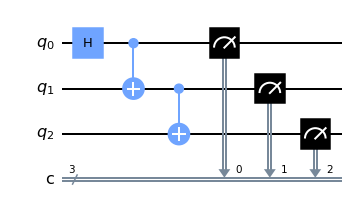

In [6]:
%matplotlib inline
circuit.draw(output='mpl')

In [7]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend = simulator, shots=1024).result()

In [8]:
from qiskit.visualization import plot_histogram

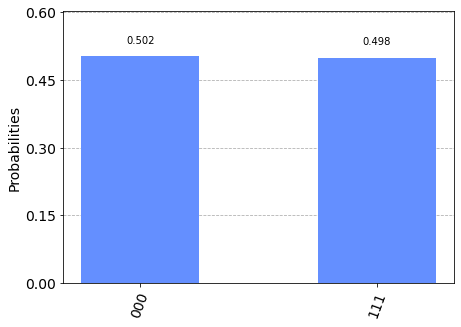

In [9]:
plot_histogram(sim_result.get_counts(circuit))

In [10]:
provider = IBMQ.get_provider('ibm-q')
for backend in provider.backends():
    try:
        qubit_count = len(backend.properties().qubits)
    except:
        qubit_count = "simulated"
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {qubit_count} qubits")

ibmq_qasm_simulator has 2 queued and simulated qubits
ibmq_lima has 0 queued and 5 qubits
ibmq_belem has 0 queued and 5 qubits
ibmq_quito has 0 queued and 5 qubits
simulator_statevector has 2 queued and simulated qubits
simulator_mps has 2 queued and simulated qubits
simulator_extended_stabilizer has 2 queued and simulated qubits
simulator_stabilizer has 2 queued and simulated qubits
ibmq_manila has 40 queued and 5 qubits
ibm_nairobi has 68 queued and 7 qubits
ibm_oslo has 19 queued and 7 qubits


In [11]:
device = provider.get_backend('ibmq_belem')
job = execute(circuit, backend=device, shots=1024)

In [12]:
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

63d15036fc58056255f5cfaa
Job Status: job has successfully run


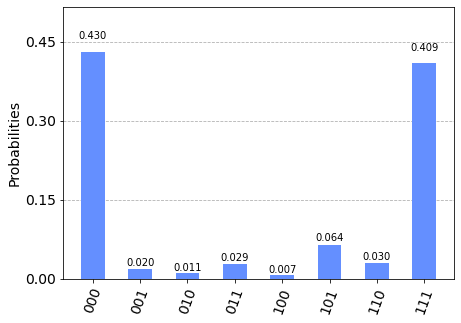

In [13]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [14]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [15]:
# print(help(complete_meas_cal))

cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0],
                                               circlabel = 'measerrormitigationcal')

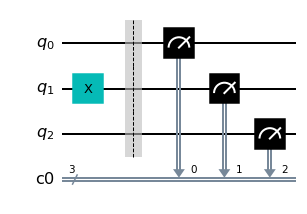

In [16]:
cal_circuits[2].draw(output='mpl')

In [17]:
len(cal_circuits)

8

In [18]:
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 1024,
                 optimization_level = 0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

63d150608eca23224d282392
Job Status: job has successfully run


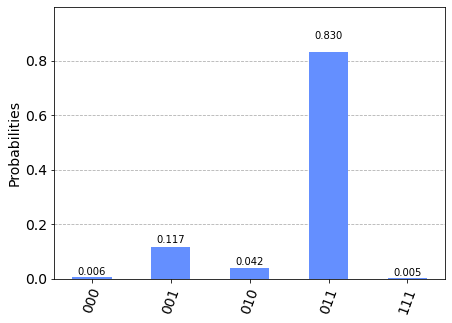

In [19]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

In [20]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

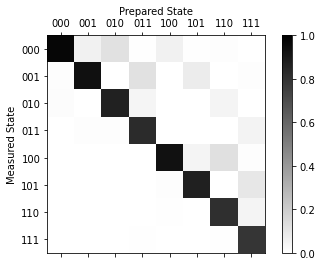

In [21]:
meas_fitter.plot_calibration()

In [22]:
meas_filter = meas_fitter.filter

In [23]:
mitigated_result = meas_filter.apply(device_result)

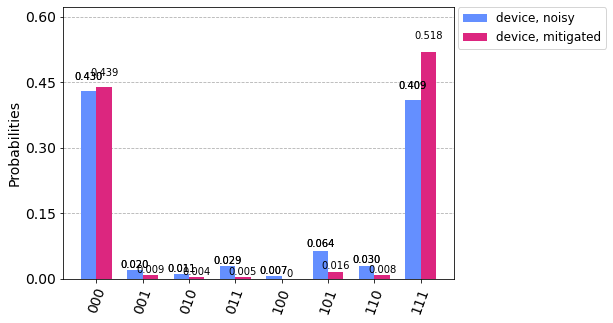

In [24]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

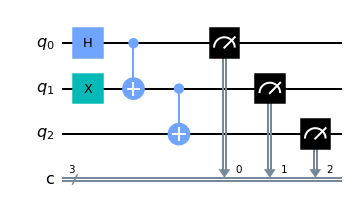

In [25]:
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2], [0,1,2])
circuit2.draw(output='mpl')

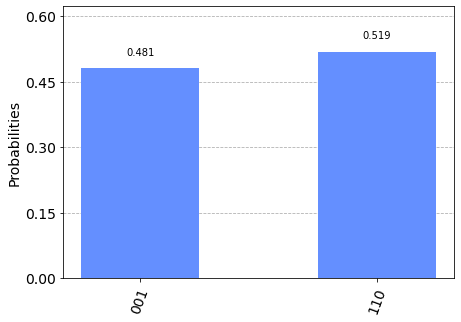

In [26]:
plot_histogram(
    execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
)

In [27]:
device_counts_2 = execute(circuit2, backend=device, shots=1024).result().get_counts(circuit2)

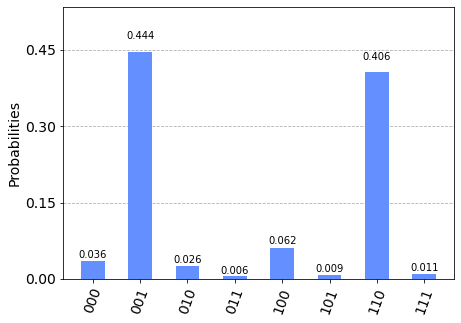

In [28]:
plot_histogram(device_counts_2)

In [29]:
device_mitigated_count_2 = meas_filter.apply(device_counts_2)

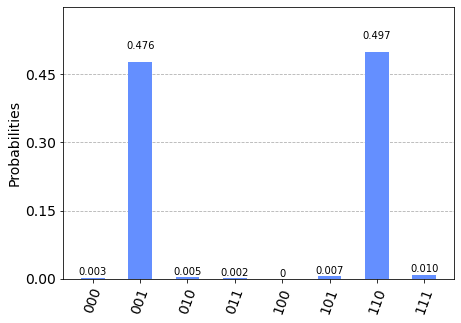

In [30]:
plot_histogram(device_mitigated_count_2)